In [4]:
from base_imputer import BaseImputer
from global_mean import GlobalMeanImputer
from random_copy import RandomTrainingSampleImputer
from knn_simple import SimpleKNNImputer
from metrics import METRICS
from typing import Dict, List
import pandas as pd
import pickle, os, json, math, itertools, numpy as np, pandas as pd
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from typing import Dict, List, Iterable, Tuple, Optional

In [5]:
def load_split_dict(path: str) -> Dict[str, pd.DataFrame]:
    with open(path, "rb") as f:
        d = pickle.load(f)
    assert isinstance(d, dict) and all(isinstance(v, pd.DataFrame) for v in d.values())
    return d

def evaluate_model(
    model: BaseImputer,
    train: Dict[str, pd.DataFrame],
    eval_split: Dict[str, pd.DataFrame],
    input_modalities: List[str],
    target_modality: str,
    metrics: Iterable[str] = ("mae", "rmse", "r2", "spearman", "pearson_featurewise","pearson_flat"),
):
    """
    Fit on train, predict on eval_split, and compute metrics for ONE target modality.
    """
    # Presence + alignment checks
    assert target_modality in train and target_modality in eval_split, \
        f"Missing modality '{target_modality}' in splits"
    assert (train[target_modality].columns == eval_split[target_modality].columns).all(), \
        f"Feature mismatch in '{target_modality}'"

    for m in input_modalities:
        assert m in train and m in eval_split, f"Missing input modality '{m}' in splits"

    model.fit(train, input_modalities, [target_modality])
    preds = model.predict(eval_split, [target_modality])

    y_true = eval_split[target_modality].to_numpy()
    y_pred = preds[target_modality].to_numpy()

    scores = {k: METRICS[k](y_true, y_pred) for k in metrics}

    results = {
        "model": model.name,
        "target": target_modality,
        "inputs": input_modalities,
        "metrics": scores,
    }
    return results, preds[target_modality]

In [7]:
train_path = "Data/ccle_split_train.pkl"
val_path   = "Data/ccle_split_val.pkl"
test_path  = "Data/ccle_split_test.pkl"

train_dict = load_split_dict(train_path)
val_dict   = load_split_dict(val_path)
test_dict  = load_split_dict(test_path)

sorted(train_dict.keys()), {m: df.shape for m, df in train_dict.items()}

(['metabolomics', 'methylation', 'miRNA', 'proteomics', 'rna'],
 {'metabolomics': (672, 225),
  'miRNA': (672, 734),
  'proteomics': (672, 214),
  'rna': (672, 2000),
  'methylation': (672, 2000)})

In [23]:
target_modalities = list(train_dict.keys())[2]
input_modalities = [m for m in train_dict if m != target_modalities]
model = SimpleKNNImputer(n_neighbors=15,seed=42)
res,pre = evaluate_model(model, train_dict, test_dict, input_modalities, target_modalities)

In [24]:
res

{'model': 'knn_simple',
 'target': 'proteomics',
 'inputs': ['metabolomics', 'miRNA', 'rna', 'methylation'],
 'metrics': {'mae': 0.6897837593340529,
  'rmse': 0.9427543473844708,
  'r2': 0.1733543997447451,
  'spearman': 0.38950440129548375,
  'pearson_featurewise': 0.41525085196755696,
  'pearson_flat': 0.42659708753157205}}

In [25]:
pre

,14-3-3_beta,14-3-3_epsilon_Caution,14-3-3_zeta,4E-BP1,4E-BP1_pS65,4E-BP1_pT37_T46,4E-BP1_pT70,53BP1,A-Raf_pS299_Caution,ACC_pS79,...,Tuberin_pT1462,VAV1_Caution,VEGFR2,VHL_Caution,XBP1_Caution,XRCC1_Caution,YAP_Caution,YAP_pS127_Caution,YB-1,YB-1_pS102
CCLE_ID,,,,,,,,,,,,,,,,,,,,,
OAW28_OVARY,-0.230342,-0.474624,-0.195158,-0.097576,-0.193392,-0.409881,-0.193690,-0.446289,-0.035487,0.059959,...,-0.435442,-0.414733,0.651563,0.876244,-0.234237,-0.268776,0.653801,0.698871,0.303698,0.193793
BFTC905_URINARY_TRACT,0.482802,0.084440,-0.252887,-0.618254,-0.586207,-0.697748,-0.267528,0.164286,0.717855,-0.148692,...,-0.249316,-0.389068,0.608668,1.113042,-0.140873,-0.357102,0.697918,0.732080,0.244038,0.161321
HEC1A_ENDOMETRIUM,0.038460,-0.151753,-0.342648,-0.011196,-0.014356,-0.175309,-0.026298,-0.181849,0.074496,0.175638,...,-0.226690,-0.371014,0.450564,-0.149539,0.079976,-0.149367,0.528794,0.368227,0.036501,0.255894
HCC56_LARGE_INTESTINE,0.266872,-0.316207,0.540772,-0.117702,-0.778176,-0.876543,-0.503754,-0.808927,0.101844,0.376635,...,-0.341558,-0.539288,0.208319,0.674001,0.220483,-0.214085,0.320716,0.465526,-0.233860,0.355507
HPBALL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-0.366050,0.077681,-0.116472,0.267633,-0.339572,-0.132426,0.130414,0.163811,-0.355659,-0.093537,...,-0.058342,1.927115,-0.738094,-0.881625,0.017826,0.524843,-1.129906,-1.372149,-0.653630,-0.881517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MFE296_ENDOMETRIUM,0.034432,-0.122521,-0.158349,-0.372926,-0.083274,-0.297654,0.023066,-0.156625,0.082354,0.054314,...,0.126174,-0.488075,0.556473,-0.191289,0.433954,0.022812,0.568766,0.530551,-0.170534,0.055084
SNU213_PANCREAS,0.110165,-0.244241,0.059825,0.281721,-0.401973,-0.079398,0.149695,-0.321620,0.482637,0.104531,...,-0.541611,-0.028769,0.989559,0.687240,-0.101383,-0.202703,0.645481,0.627786,0.310445,0.111627
KU812_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.274719,-0.065225,-0.470635,0.965672,-0.115828,0.856324,0.432329,-0.594101,0.139980,0.149552,...,0.055579,1.852500,-1.010992,-0.669769,0.632919,-0.127295,-1.311567,-1.497989,-0.517304,-0.447214


In [30]:
test_dict[target_modalities]

,14-3-3_beta,14-3-3_epsilon_Caution,14-3-3_zeta,4E-BP1,4E-BP1_pS65,4E-BP1_pT37_T46,4E-BP1_pT70,53BP1,A-Raf_pS299_Caution,ACC_pS79,...,Tuberin_pT1462,VAV1_Caution,VEGFR2,VHL_Caution,XBP1_Caution,XRCC1_Caution,YAP_Caution,YAP_pS127_Caution,YB-1,YB-1_pS102
CCLE_ID,,,,,,,,,,,,,,,,,,,,,
OAW28_OVARY,-0.039263,11.368095,-0.031960,-1.503290,-0.223327,-1.152376,0.029175,-0.010941,-0.916097,1.970971,...,-0.967184,-0.840206,-0.052892,1.308839,-0.681601,0.381072,1.159223,0.688754,0.344970,-0.283063
BFTC905_URINARY_TRACT,-1.259306,-0.816341,1.156641,-0.290421,-0.404103,-0.077438,-0.642478,0.032455,-0.664347,1.678390,...,-0.675433,-0.880141,0.288661,0.978761,0.766840,-0.364846,-0.456106,0.638292,0.514919,1.701258
HEC1A_ENDOMETRIUM,0.357841,-0.827346,-0.054018,-0.502771,-1.116840,-0.361982,-0.761002,-2.141214,-0.607868,-0.317474,...,-0.537252,-0.377527,-0.262154,-0.560839,1.532181,0.278445,0.522181,0.719186,-0.787304,0.579147
HCC56_LARGE_INTESTINE,0.915572,-0.331542,0.386314,-0.106724,-1.501735,-1.584613,-1.173148,1.366228,1.453223,0.531751,...,3.038055,-0.114611,-0.126722,-0.903057,-0.068958,-0.368153,-0.279279,0.010744,-1.043247,0.524080
HPBALL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-0.463198,0.111063,0.065968,0.178210,-0.066393,-0.581702,0.163033,-0.869608,0.322843,-0.017406,...,-0.272043,2.090143,-0.829479,-0.884307,0.165977,0.578862,-1.466472,-1.162105,-0.683317,-2.467836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MFE296_ENDOMETRIUM,-0.777421,0.269095,-0.669802,-0.265773,0.482562,0.550460,-0.833620,1.408092,-0.176092,1.243230,...,2.113394,-0.395004,-0.205275,1.650865,0.717488,1.456827,-0.103526,0.145380,-0.212297,-1.031644
SNU213_PANCREAS,1.491083,0.082539,0.660147,1.207024,-0.134599,0.329605,0.184528,-1.367852,0.607848,0.236500,...,-0.930569,-0.728744,1.611546,-0.037835,-1.095086,-0.020741,1.014054,1.152147,-0.478060,-0.926189
KU812_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-1.426671,-0.177270,-0.328020,1.248236,0.596469,1.167049,2.040652,-0.457269,-0.417512,-0.509979,...,-1.224926,1.959495,-1.378633,-0.931992,-0.832728,-0.262285,-1.219103,-1.946860,0.067075,0.270284


0.42659708753157205


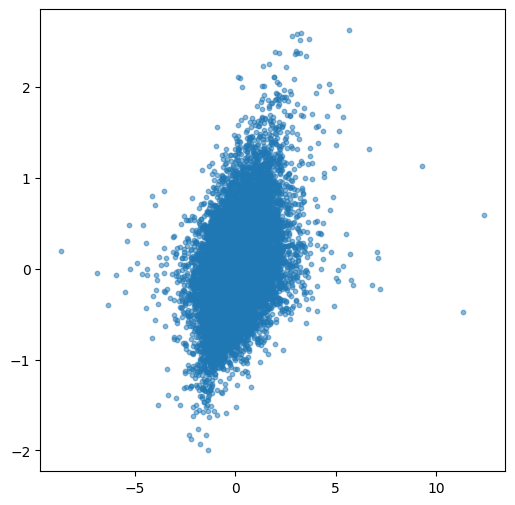

In [34]:
import matplotlib.pyplot as plt
# flatten
y_true = test_dict[target_modalities].to_numpy().ravel()
y_pred = pre.to_numpy().ravel()

#print correlation
print(pearsonr(y_true.ravel(), y_pred.ravel())[0])

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5, s=10)

In [27]:
pre.loc['OAW28_OVARY']

14-3-3_beta              -0.230342
14-3-3_epsilon_Caution   -0.474624
14-3-3_zeta              -0.195158
4E-BP1                   -0.097576
4E-BP1_pS65              -0.193392
                            ...   
XRCC1_Caution            -0.268776
YAP_Caution               0.653801
YAP_pS127_Caution         0.698871
YB-1                      0.303698
YB-1_pS102                0.193793
Name: OAW28_OVARY, Length: 214, dtype: float64

In [28]:
pre['14-3-3_beta']

CCLE_ID
OAW28_OVARY                                 -0.230342
BFTC905_URINARY_TRACT                        0.482802
HEC1A_ENDOMETRIUM                            0.038460
HCC56_LARGE_INTESTINE                        0.266872
HPBALL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE   -0.366050
                                               ...   
MFE296_ENDOMETRIUM                           0.034432
SNU213_PANCREAS                              0.110165
KU812_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE     0.274719
HPAFII_PANCREAS                              0.391912
NCIH2029_LUNG                               -0.886514
Name: 14-3-3_beta, Length: 78, dtype: float64

,14-3-3_beta,14-3-3_epsilon_Caution,14-3-3_zeta,4E-BP1,4E-BP1_pS65,4E-BP1_pT37_T46,4E-BP1_pT70,53BP1,A-Raf_pS299_Caution,ACC_pS79,...,Tuberin_pT1462,VAV1_Caution,VEGFR2,VHL_Caution,XBP1_Caution,XRCC1_Caution,YAP_Caution,YAP_pS127_Caution,YB-1,YB-1_pS102
CCLE_ID,,,,,,,,,,,,,,,,,,,,,
OAW28_OVARY,-0.039263,11.368095,-0.031960,-1.503290,-0.223327,-1.152376,0.029175,-0.010941,-0.916097,1.970971,...,-0.967184,-0.840206,-0.052892,1.308839,-0.681601,0.381072,1.159223,0.688754,0.344970,-0.283063
BFTC905_URINARY_TRACT,-1.259306,-0.816341,1.156641,-0.290421,-0.404103,-0.077438,-0.642478,0.032455,-0.664347,1.678390,...,-0.675433,-0.880141,0.288661,0.978761,0.766840,-0.364846,-0.456106,0.638292,0.514919,1.701258
HEC1A_ENDOMETRIUM,0.357841,-0.827346,-0.054018,-0.502771,-1.116840,-0.361982,-0.761002,-2.141214,-0.607868,-0.317474,...,-0.537252,-0.377527,-0.262154,-0.560839,1.532181,0.278445,0.522181,0.719186,-0.787304,0.579147
HCC56_LARGE_INTESTINE,0.915572,-0.331542,0.386314,-0.106724,-1.501735,-1.584613,-1.173148,1.366228,1.453223,0.531751,...,3.038055,-0.114611,-0.126722,-0.903057,-0.068958,-0.368153,-0.279279,0.010744,-1.043247,0.524080
HPBALL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-0.463198,0.111063,0.065968,0.178210,-0.066393,-0.581702,0.163033,-0.869608,0.322843,-0.017406,...,-0.272043,2.090143,-0.829479,-0.884307,0.165977,0.578862,-1.466472,-1.162105,-0.683317,-2.467836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MFE296_ENDOMETRIUM,-0.777421,0.269095,-0.669802,-0.265773,0.482562,0.550460,-0.833620,1.408092,-0.176092,1.243230,...,2.113394,-0.395004,-0.205275,1.650865,0.717488,1.456827,-0.103526,0.145380,-0.212297,-1.031644
SNU213_PANCREAS,1.491083,0.082539,0.660147,1.207024,-0.134599,0.329605,0.184528,-1.367852,0.607848,0.236500,...,-0.930569,-0.728744,1.611546,-0.037835,-1.095086,-0.020741,1.014054,1.152147,-0.478060,-0.926189
KU812_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-1.426671,-0.177270,-0.328020,1.248236,0.596469,1.167049,2.040652,-0.457269,-0.417512,-0.509979,...,-1.224926,1.959495,-1.378633,-0.931992,-0.832728,-0.262285,-1.219103,-1.946860,0.067075,0.270284
